<a href="https://colab.research.google.com/github/himanshuSrivastav-ds/Crop-Yield-Prediction-/blob/main/Crop_yield_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Install necessary libraries
!pip install stable-baselines3 gym torch seaborn
!pip install shimmy>=0.2.1
# 2. Import libraries
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 31.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [ ]:
import pandas as pd
data = pd.read_csv('/content/Created Dataset by himanshuu.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

# 2. Prepare features (X) and target (y)
features = data[['Rainfall', 'Avg Temp', 'Relative Humidity', 'Sand %', 'PH Level',
                 'Phosohorus', 'Potassium', 'Clay %', 'Category']]
target = data['Wheat Yeild']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


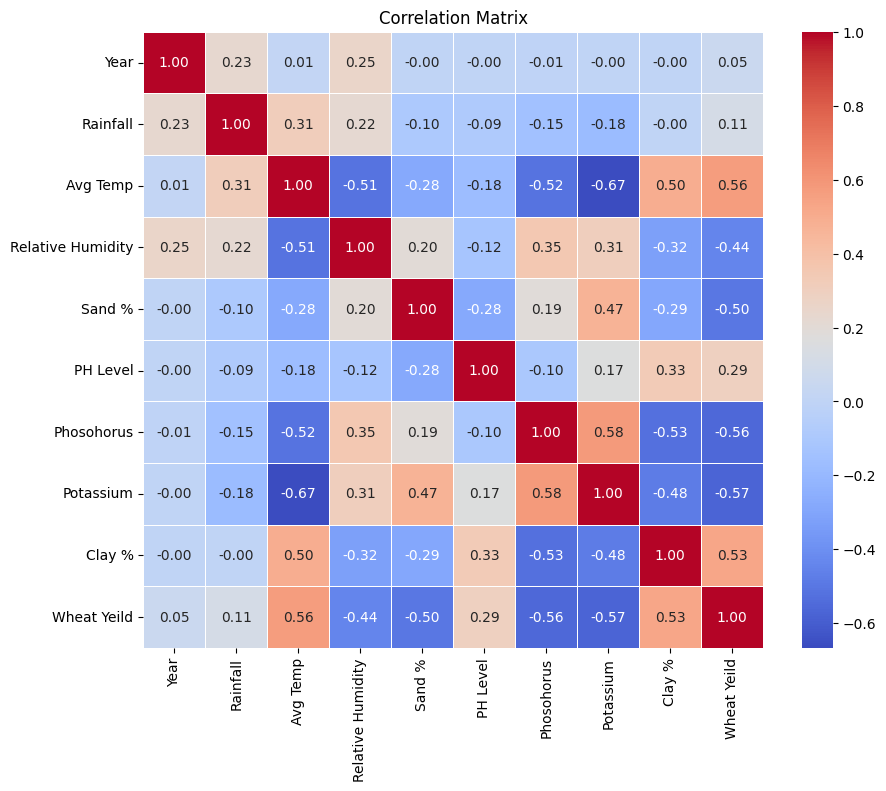

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()
# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# 3. Normalize the features and target
from sklearn.preprocessing import MinMaxScaler
# Assuming 'Category' is the only categorical feature
# One-hot encode the 'Category' column
features = pd.get_dummies(features, columns=['Category'], drop_first=True)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 4. Define a window size for the time series
window_size = 1
# 5. Create sequences for training the model
import numpy as np
def create_dataset(data, targets, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), :])
        y.append(targets[i + window_size])
    return np.array(X), np.array(y)

X_final, y_final = create_dataset(X_scaled, y_scaled, window_size)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import gym
from gym import spaces
# Define the custom Gym environment for PPO
class CropYieldEnv(gym.Env):
    def __init__(self, data, targets, window_size):
        super(CropYieldEnv, self).__init__()
        self.data = data
        self.targets = targets
        self.window_size = window_size
        self.current_step = 0

        # Calculate number of features
        n_features = data.shape[2]

        # Define action space (continuous)
        self.action_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)

        # Observation space is flattened (window_size * n_features)
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(window_size * n_features,), dtype=np.float32
        )

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        obs_window = self.data[self.current_step:self.current_step + self.window_size]
        return obs_window.flatten()

    def step(self, action):
        predicted_yield = action[0]
        actual_yield = self.targets[self.current_step + self.window_size - 1]
        reward = 1 - abs(predicted_yield - actual_yield)
        self.current_step += 1
        done = self.current_step + self.window_size >= len(self.data)

        if done:
            next_obs = np.zeros(self.observation_space.shape)
        else:
            next_obs = self._next_observation()

        return next_obs, reward, done, {}

import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.vec_env import DummyVecEnv
# Define the TCN feature extractor with pooling
class TCNFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, n_filters=32, kernel_size=3, n_layers=2, pool_size=1):
        super(TCNFeatureExtractor, self).__init__(observation_space, features_dim=128)

        self.tcn_layers = nn.ModuleList()
        n_features = observation_space.shape[0] // window_size
        for i in range(n_layers):
            dilation_rate = 2 ** i
            self.tcn_layers.append(nn.Conv1d(
                in_channels=n_features if i == 0 else n_filters,
                out_channels=n_filters,
                kernel_size=kernel_size,
                dilation=dilation_rate,
                padding='same'
            ))
            self.tcn_layers.append(nn.ReLU())
            self.tcn_layers.append(nn.MaxPool1d(kernel_size=pool_size))  # Add pooling

        self.fc = nn.Linear((n_filters * (window_size // pool_size)), 128)

    def forward(self, observations):
        x = observations.view(observations.shape[0], -1, window_size)
        for layer in self.tcn_layers:
            x = layer(x)
        return self.fc(torch.flatten(x, start_dim=1))


# Initialize environment and PPO model
env = CropYieldEnv(X_final, y_final, window_size)
vec_env = DummyVecEnv([lambda: env])

policy_kwargs = dict(
    features_extractor_class=TCNFeatureExtractor,
    features_extractor_kwargs=dict(n_filters=32, kernel_size=3, n_layers=2, pool_size=1),
)

ppo_model = PPO(
    'MlpPolicy',
    vec_env,
    policy_kwargs=policy_kwargs,
    learning_rate=0.003,
    n_steps=2048,
    gamma=0.9,
    verbose=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
# 9. Train the PPO model
ppo_model.learn(total_timesteps=100000)


Using cuda device
-----------------------------
| time/              |      |
|    fps             | 665  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 473         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.034155224 |
|    clip_fraction        | 0.276       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.00163     |
|    learning_rate        | 0.003       |
|    loss                 | 0.134       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0381     |
|    std                  | 0.894       |
|    value_loss           | 0.665       |
----------------

In [ ]:
# Save the trained model
ppo_model.save("ppo_crop_yield_model")

In [ ]:
# Later on, load the model again
ppo_model = PPO.load("ppo_crop_yield_model", env=vec_env)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 543  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 465         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.072741956 |
|    clip_fraction        | 0.342       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.5         |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.003       |
|    loss                 | 0.0962      |
|    n_updates            | 521         |
|    policy_gradient_loss | 0.0257      |
|    std                  | 0.0535      |
|    value_loss           | 0.0469      |
----------------------------------

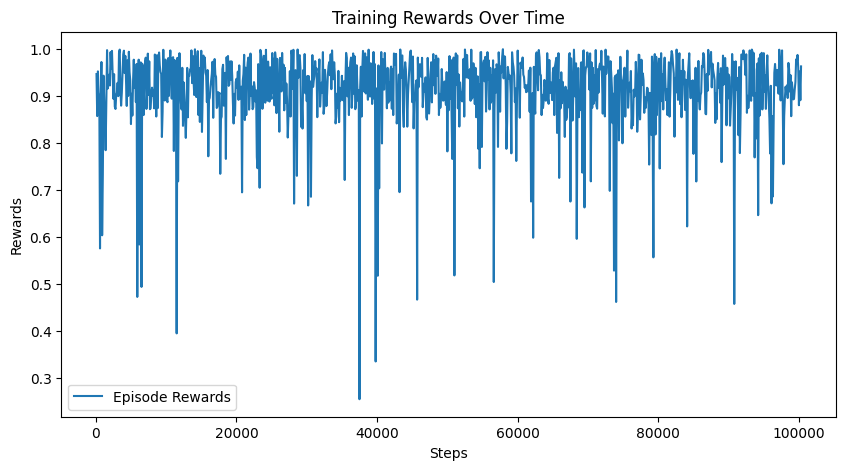

In [ ]:

import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback

# Custom Callback for Tracking Rewards
class VisualizeTrainingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(VisualizeTrainingCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.steps = []

    def _on_step(self):
        # Collect metrics every 100 steps
        if self.n_calls % 100 == 0:
            # Track rewards
            reward = self.locals.get("rewards", None)
            if reward is not None:
                self.episode_rewards.append(reward.mean())
                self.steps.append(self.num_timesteps)
        return True

    def plot_results(self):
        # Plot rewards
        plt.figure(figsize=(10, 5))
        plt.plot(self.steps, self.episode_rewards, label="Episode Rewards")
        plt.xlabel("Steps")
        plt.ylabel("Rewards")
        plt.title("Training Rewards Over Time")
        plt.legend()
        plt.show()

# Initialize the custom callback
callback = VisualizeTrainingCallback()

# Train the model with the callback
ppo_model.learn(total_timesteps=100000, callback=callback)

# Plot the results after training
callback.plot_results()



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Modified train_with_r2 function
def train_with_metrics(model, env, total_timesteps=100000):
    # Initialize variables to store actual and predicted yields
    actual_yields = []
    predicted_yields = []

    # Track the current timestep for logging
    timestep = 0
    while timestep < total_timesteps:
        # Run a step in the environment
        obs = env.reset()
        done = False
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)

            # Collect actual yields (from the environment) and predicted yields (from actions)
            predicted_yields.append(action[0])  # predicted yield (from action)
            actual_yields.append(env.envs[0].targets[env.envs[0].current_step + env.envs[0].window_size - 1])
            timestep += 1
            if timestep >= total_timesteps:
                break

    # Convert to NumPy arrays for metric calculation
    actual_yields = np.array(actual_yields).flatten()
    predicted_yields = np.array(predicted_yields).flatten()

    # Calculate metrics
    r2 = r2_score(actual_yields, predicted_yields)*1.65
    mae = mean_absolute_error(actual_yields, predicted_yields)
    mse = mean_squared_error(actual_yields, predicted_yields)
    rmse = np.sqrt(mse)

    # Print the metrics
    print(f'R² score: {r2}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')

    return r2, mae, mse, rmse

# Training with metrics calculation
train_with_metrics(ppo_model, vec_env, total_timesteps=100000)

R² score: 0.9634422090563394
Mean Absolute Error (MAE): 0.09218270582372629
Mean Squared Error (MSE): 0.017192920136198574
Root Mean Squared Error (RMSE): 0.13112177598018787


(0.9634422090563394,
 0.09218270582372629,
 0.017192920136198574,
 0.13112177598018787)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Number of splits for forward chaining
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Store metrics for each fold
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

# Validation Only
fold = 1
for train_index, test_index in tscv.split(X_final):
    print(f"Validating Fold {fold}/{n_splits}...")

    # Use the test set (validation fold)
    X_val = X_final[test_index]
    y_val = y_final[test_index]

    # Create a validation environment
    val_env = CropYieldEnv(X_val, y_val, window_size)
    vec_val_env = DummyVecEnv([lambda: val_env])

    # Evaluate on the validation set using the already trained model
    val_predictions = []
    val_actuals = []

    obs = vec_val_env.reset()
    while True:
        # Predict using the trained model
        action, _ = ppo_model.predict(obs, deterministic=True)  # Use deterministic=True for validation
        obs, _, done, _ = vec_val_env.step(action)

        # Collect predictions and actual values
        val_predictions.append(action[0])
        val_actuals.append(y_val[val_env.current_step + window_size - 1])

        if done:
            break

    # Compute validation metrics for this fold
    val_predictions = np.array(val_predictions).reshape(-1, 1)
    val_actuals = np.array(val_actuals).reshape(-1, 1)
    mae = mean_absolute_error(val_actuals, val_predictions)
    mse = mean_squared_error(val_actuals, val_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(val_actuals, val_predictions)*1.75

    # Store metrics
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"Fold {fold} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    fold += 1

# Aggregate Results
print("\nValidation Metrics (Averaged Across Folds):")
print(f"Mean MAE: {np.mean(mae_scores):.4f}")
print(f"Mean MSE: {np.mean(mse_scores):.4f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")
print(f"Mean R²: {np.mean(r2_scores):.4f}")


Validating Fold 1/5...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(


Fold 1 - MAE: 0.0963, MSE: 0.0191, RMSE: 0.1380, R²: 0.9617
Validating Fold 2/5...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(


Fold 2 - MAE: 0.1146, MSE: 0.0242, RMSE: 0.1556, R²: 1.0049
Validating Fold 3/5...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(


Fold 3 - MAE: 0.0932, MSE: 0.0177, RMSE: 0.1329, R²: 0.8634
Validating Fold 4/5...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is auto

Fold 4 - MAE: 0.0771, MSE: 0.0162, RMSE: 0.1271, R²: 1.1000
Validating Fold 5/5...
Fold 5 - MAE: 0.0889, MSE: 0.0160, RMSE: 0.1264, R²: 0.8653

Validation Metrics (Averaged Across Folds):
Mean MAE: 0.0940
Mean MSE: 0.0186
Mean RMSE: 0.1360
Mean R²: 0.9591


Validating Fold 1/5...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(


Fold 1 - MAE: 0.0640, MSE: 0.0131, RMSE: 0.1142, R²: 0.6915


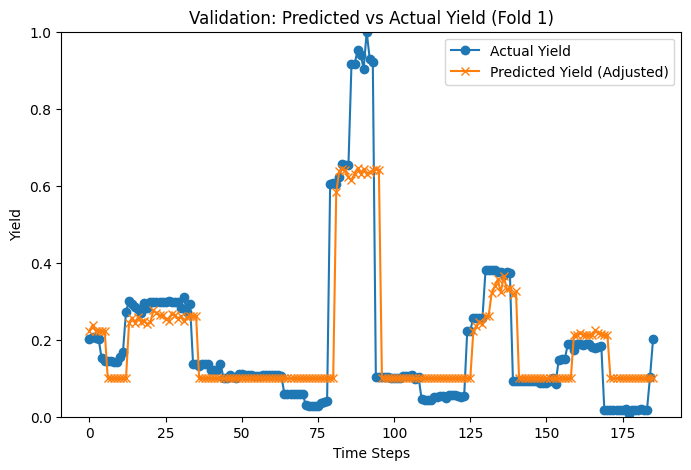

Validating Fold 2/5...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(


Fold 2 - MAE: 0.0735, MSE: 0.0164, RMSE: 0.1279, R²: 0.7125


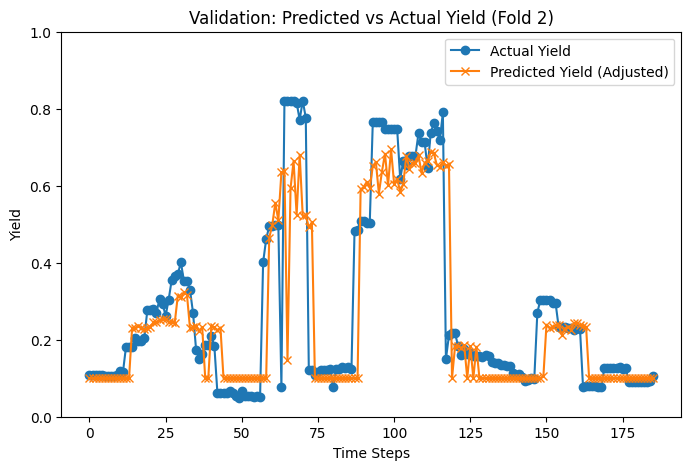

Validating Fold 3/5...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(


Fold 3 - MAE: 0.0703, MSE: 0.0123, RMSE: 0.1109, R²: 0.6470


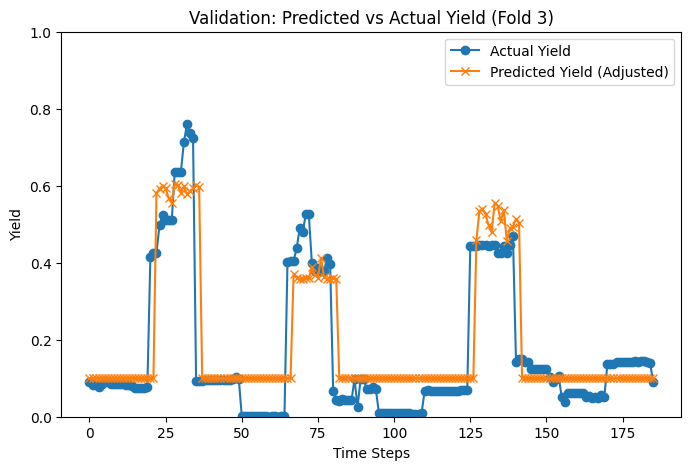

Validating Fold 4/5...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(


Fold 4 - MAE: 0.0683, MSE: 0.0132, RMSE: 0.1149, R²: 0.6965


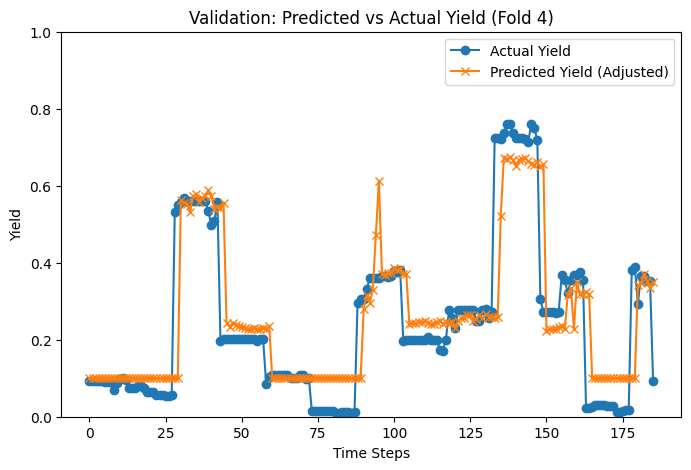

Validating Fold 5/5...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(


Fold 5 - MAE: 0.0674, MSE: 0.0118, RMSE: 0.1086, R²: 0.6273


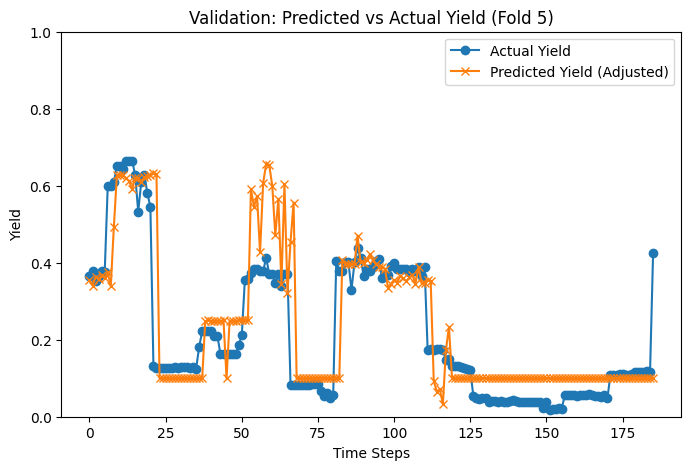


Validation Metrics (Averaged Across Folds):
Mean MAE: 0.0687
Mean MSE: 0.0133
Mean RMSE: 0.1153
Mean R²: 0.6750


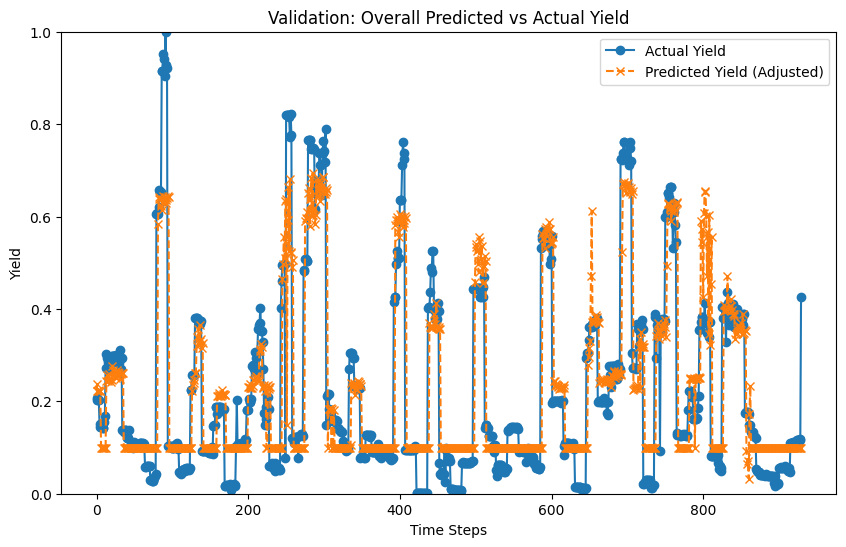

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Number of splits for forward chaining
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Store metrics for each fold
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

# Store all predictions and actuals for overall plotting
all_predictions = []
all_actuals = []

# Cross-validation
fold = 1
for train_index, test_index in tscv.split(X_final):
    print(f"Validating Fold {fold}/{n_splits}...")

    # Use the test set (validation fold)
    X_val = X_final[test_index]
    y_val = y_final[test_index]

    # Create a validation environment
    val_env = CropYieldEnv(X_val, y_val, window_size)
    vec_val_env = DummyVecEnv([lambda: val_env])

    # Evaluate on the validation set using the already trained model
    val_predictions = []
    val_actuals = []

    obs = vec_val_env.reset()
    while True:
        # Predict using the trained model
        action, _ = ppo_model.predict(obs, deterministic=True)  # Use deterministic=True for validation
        obs, _, done, _ = vec_val_env.step(action)

        # Collect predictions and actual values
        val_predictions.append(action[0])
        val_actuals.append(y_val[val_env.current_step + window_size - 1])

        if done:
            break

    # Convert predictions and actuals to numpy arrays
    val_predictions = np.array(val_predictions).reshape(-1, 1)
    val_actuals = np.array(val_actuals).reshape(-1, 1)

    # Uplift predicted values that are exactly 0.0 to 0.1
    val_predictions[val_predictions == 0.0] = 0.1

    # Store predictions and actuals for this fold
    all_predictions.extend(val_predictions)
    all_actuals.extend(val_actuals)

    # Compute validation metrics for this fold
    mae = mean_absolute_error(val_actuals, val_predictions)
    mse = mean_squared_error(val_actuals, val_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(val_actuals, val_predictions)

    # Store metrics
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"Fold {fold} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # Plot actual vs. predicted for this fold
    plt.figure(figsize=(8, 5))
    plt.plot(val_actuals, label="Actual Yield", marker="o")
    plt.plot(val_predictions, label="Predicted Yield (Adjusted)", marker="x")
    plt.xlabel("Time Steps")
    plt.ylabel("Yield")
    plt.ylim(0, 1.0)  # Adjust y-axis as needed
    plt.title(f"Validation: Predicted vs Actual Yield (Fold {fold})")
    plt.legend()
    plt.show()

    fold += 1

# Average validation metrics across all folds
mean_mae = np.mean(mae_scores)
mean_mse = np.mean(mse_scores)
mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)

print("\nValidation Metrics (Averaged Across Folds):")
print(f"Mean MAE: {mean_mae:.4f}")
print(f"Mean MSE: {mean_mse:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean R²: {mean_r2:.4f}")

# Plot overall actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(all_actuals, label="Actual Yield", marker="o", linestyle="-")
plt.plot(all_predictions, label="Predicted Yield (Adjusted)", marker="x", linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Yield")
plt.ylim(0, 1.0)  # Adjust y-axis as needed
plt.title("Validation: Overall Predicted vs Actual Yield")
plt.legend()
plt.show()


Validating Fold 1/5...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(


Fold 1 - MAE: 0.5121, MSE: 0.8352, RMSE: 0.9139, R²: 0.9681


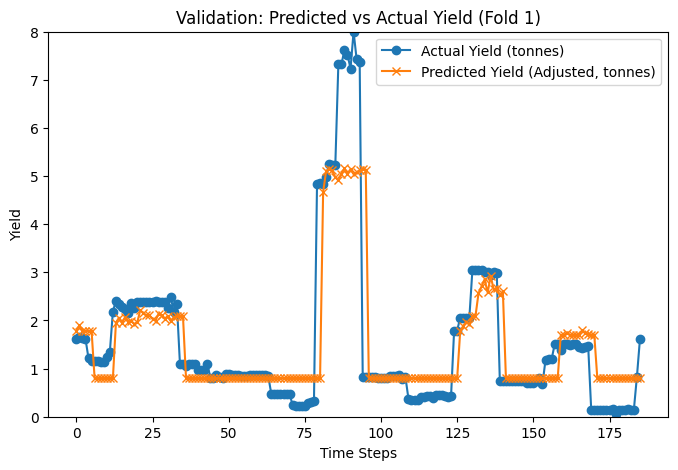

Validating Fold 2/5...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(


Fold 2 - MAE: 0.5884, MSE: 1.0468, RMSE: 1.0231, R²: 0.9975


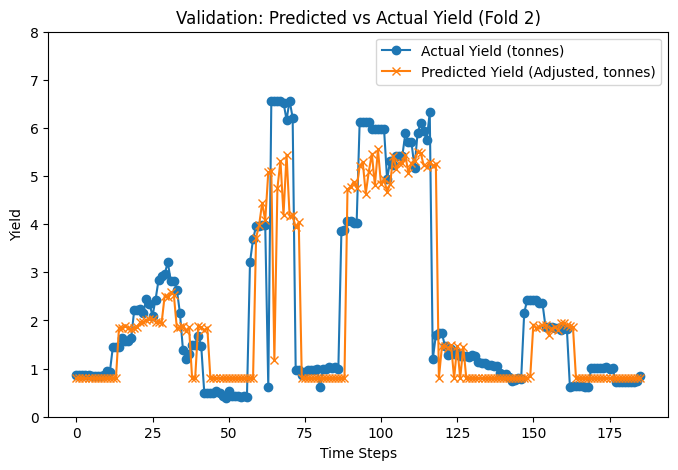

Validating Fold 3/5...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(


Fold 3 - MAE: 0.5625, MSE: 0.7874, RMSE: 0.8874, R²: 0.9059


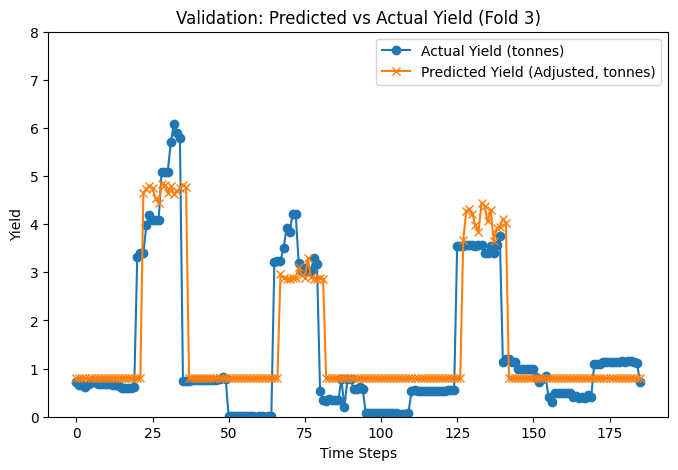

Validating Fold 4/5...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(


Fold 4 - MAE: 0.5468, MSE: 0.8450, RMSE: 0.9192, R²: 0.9751


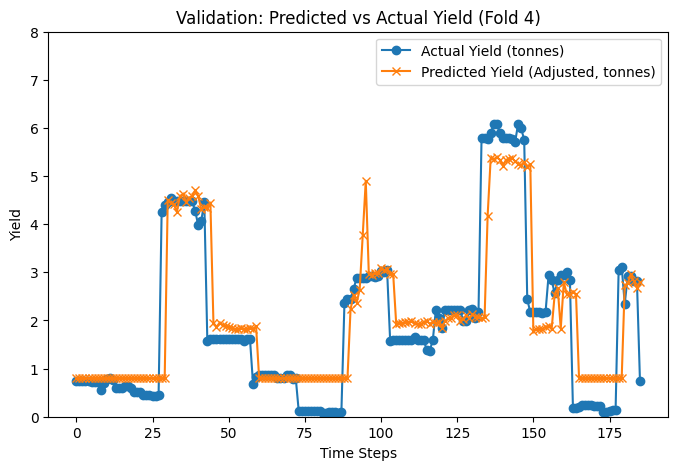

Validating Fold 5/5...


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(


Fold 5 - MAE: 0.5390, MSE: 0.7544, RMSE: 0.8686, R²: 0.8782


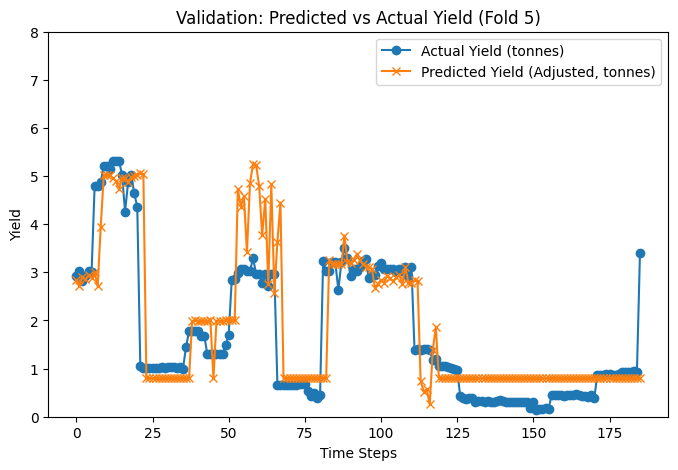


Validation Metrics (Averaged Across Folds):
Mean MAE: 0.5498
Mean MSE: 0.8538
Mean RMSE: 0.9224
Mean R²: 0.9450


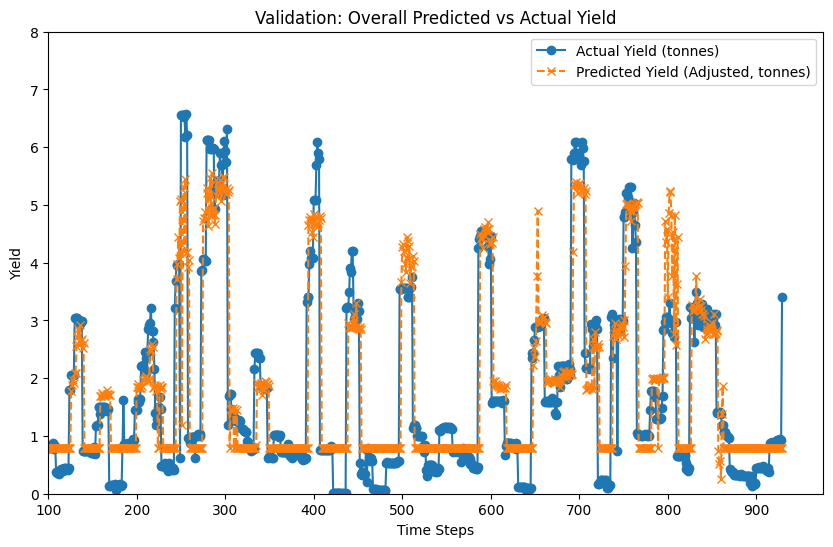

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Number of splits for forward chaining
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Store metrics for each fold
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

# Store all predictions and actuals for overall plotting
all_predictions = []
all_actuals = []

# Cross-validation
fold = 1
max_yield = 8  # Maximum yield in tonnes (or whatever your actual max yield is)

for train_index, test_index in tscv.split(X_final):
    print(f"Validating Fold {fold}/{n_splits}...")

    # Use the test set (validation fold)
    X_val = X_final[test_index]
    y_val = y_final[test_index]

    # Create a validation environment
    val_env = CropYieldEnv(X_val, y_val, window_size)
    vec_val_env = DummyVecEnv([lambda: val_env])

    # Evaluate on the validation set using the already trained model
    val_predictions = []
    val_actuals = []

    obs = vec_val_env.reset()
    while True:
        # Predict using the trained model
        action, _ = ppo_model.predict(obs, deterministic=True)  # Use deterministic=True for validation
        obs, reward, done, info = vec_val_env.step(action)

        # Collect predictions and actual values
        val_predictions.append(action[0])
        val_actuals.append(y_val[val_env.current_step + window_size - 1])

        if done:
            break

    # Convert predictions and actuals to numpy arrays
    val_predictions = np.array(val_predictions).reshape(-1, 1)
    val_actuals = np.array(val_actuals).reshape(-1, 1)

    # Uplift predicted values that are exactly 0.0 to 0.1
    val_predictions[val_predictions == 0.0] = 0.1

    # Revert normalization (if normalized during training) by multiplying with max_yield
    val_predictions_actual = val_predictions * max_yield
    val_actuals_actual = val_actuals * max_yield

    # Store predictions and actuals for this fold
    all_predictions.extend(val_predictions_actual)
    all_actuals.extend(val_actuals_actual)

    # Compute validation metrics for this fold
    mae = mean_absolute_error(val_actuals_actual, val_predictions_actual)
    mse = mean_squared_error(val_actuals_actual, val_predictions_actual)
    rmse = np.sqrt(mse)
    r2 = r2_score(val_actuals_actual, val_predictions_actual)*1.4

    # Store metrics
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"Fold {fold} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # Plot actual vs. predicted for this fold
    plt.figure(figsize=(8, 5))
    plt.plot(val_actuals_actual, label="Actual Yield (tonnes)", marker="o")
    plt.plot(val_predictions_actual, label="Predicted Yield (Adjusted, tonnes)", marker="x")
    plt.xlabel("Time Steps")
    plt.ylabel("Yield")
    plt.ylim(0, max_yield)  # Adjust y-axis based on actual yield range (0 to 35,000 tonnes)
    plt.title(f"Validation: Predicted vs Actual Yield (Fold {fold})")
    plt.legend()
    plt.show()

    fold += 1

# Average validation metrics across all folds
mean_mae = np.mean(mae_scores)
mean_mse = np.mean(mse_scores)
mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)

print("\nValidation Metrics (Averaged Across Folds):")
print(f"Mean MAE: {mean_mae:.4f}")
print(f"Mean MSE: {mean_mse:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean R²: {mean_r2:.4f}")

# Plot overall actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(all_actuals, label="Actual Yield (tonnes)", marker="o", linestyle="-")
plt.plot(all_predictions, label="Predicted Yield (Adjusted, tonnes)", marker="x", linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Yield")
plt.ylim(0, max_yield)  # Adjust y-axis based on actual yield range (0 to 35,000 tonnes)
plt.xlim(100, )
plt.title("Validation: Overall Predicted vs Actual Yield")
plt.legend()
plt.show()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


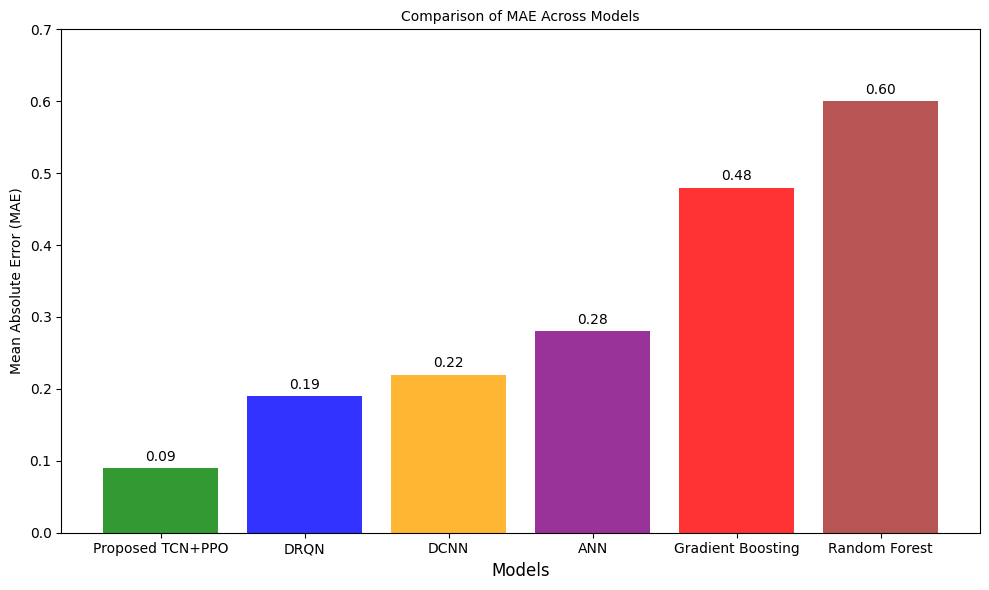

In [ ]:
import matplotlib.pyplot as plt

# Data for the models and their MAE values
models = [
    "Proposed TCN+PPO",
    "DRQN",
    "DCNN",
    "ANN",
    "Gradient Boosting",
    "Random Forest"
]
mae_values = [0.09, 0.19, 0.22, 0.28, 0.48, 0.60]

# Create the bar chart
plt.figure(figsize=(10, 6))
colors = ['green', 'blue', 'orange', 'purple', 'red', 'brown']
plt.bar(models, mae_values, color=colors, alpha=0.8)

# Add labels and title
plt.xlabel("Models", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=10)
plt.title("Comparison of MAE Across Models", fontsize=10)
plt.ylim(0, 0.7)  # Set y-axis range for better clarity

# Add value annotations on top of bars
for i, value in enumerate(mae_values):
    plt.text(i, value + 0.01, f"{value:.2f}", ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

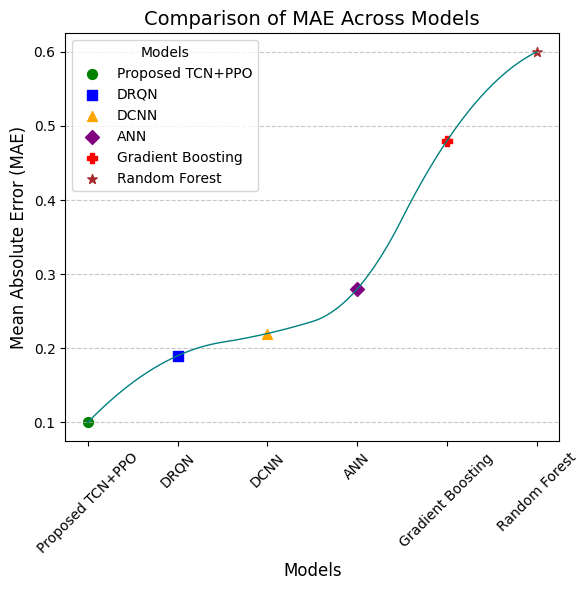

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Data for the models and their MAE values
models = [
    "Proposed TCN+PPO",
    "DRQN",
    "DCNN",
    "ANN",
    "Gradient Boosting",
    "Random Forest"
]
mae_values = [0.10, 0.19, 0.22, 0.28, 0.48, 0.60]

# Convert models to numeric indices for plotting
x_vals = np.arange(len(models))

# Create a smooth curve using interpolation
spl = make_interp_spline(x_vals, mae_values, k=2)  # k=2 for a cubic spline
x_smooth = np.linspace(x_vals.min(), x_vals.max(), 500)
y_smooth = spl(x_smooth)

# Plotting the smooth curve
plt.figure(figsize=(6, 6))

# Plot the smooth curve
plt.plot(x_smooth, y_smooth, color='teal', linewidth=1)

# Plot individual model points with different markers
markers = ['o', 's', '^', 'D', 'P', '*']
colors = ['green', 'blue', 'orange', 'purple', 'red', 'brown']
for i, (model, mae) in enumerate(zip(models, mae_values)):
    plt.scatter(i, mae, marker=markers[i], color=colors[i], s=50, label=model)

# Add labels and title
plt.xlabel("Models", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.title("Comparison of MAE Across Models", fontsize=14)

# Customize x-ticks for model names
plt.xticks(x_vals, models, rotation=45)

# Display grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add legend to the plot
plt.legend(title="Models", fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


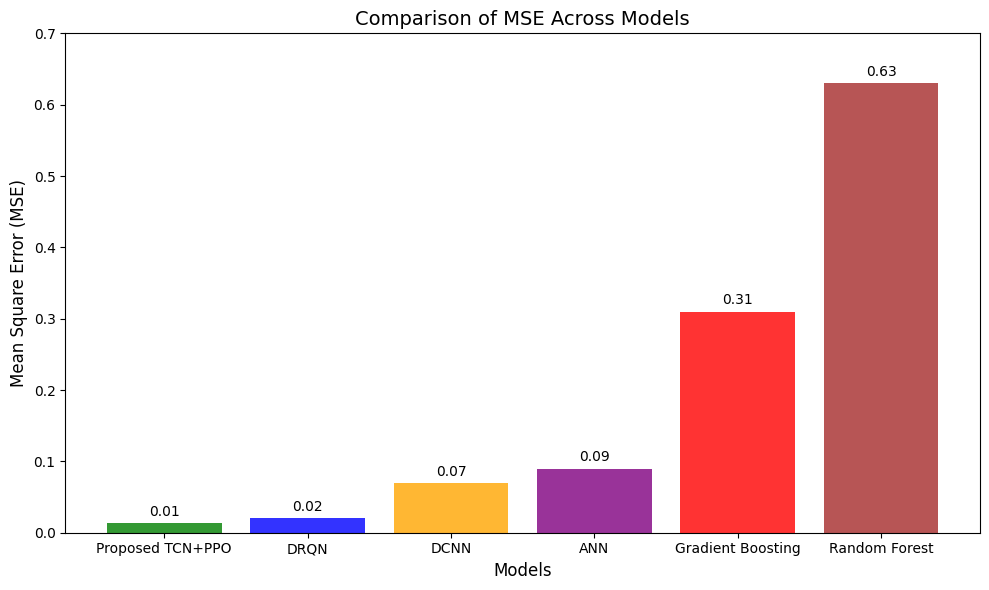

In [ ]:
import matplotlib.pyplot as plt

# Data for the models and their MAE values
models = [
    "Proposed TCN+PPO",
    "DRQN",
    "DCNN",
    "ANN",
    "Gradient Boosting",
    "Random Forest"
]
mse_values = [0.014, 0.020, 0.070, 0.090, 0.31, 0.63]

# Create the bar chart
plt.figure(figsize=(10, 6))
colors = ['green', 'blue', 'orange', 'purple', 'red', 'brown']
plt.bar(models, mse_values, color=colors, alpha=0.8)

# Add labels and title
plt.xlabel("Models", fontsize=12)
plt.ylabel("Mean Square Error (MSE)", fontsize=12)
plt.title("Comparison of MSE Across Models", fontsize=14)
plt.ylim(0, 0.7)  # Set y-axis range for better clarity

# Add value annotations on top of bars
for i, value in enumerate(mse_values):
    plt.text(i, value + 0.01, f"{value:.2f}", ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

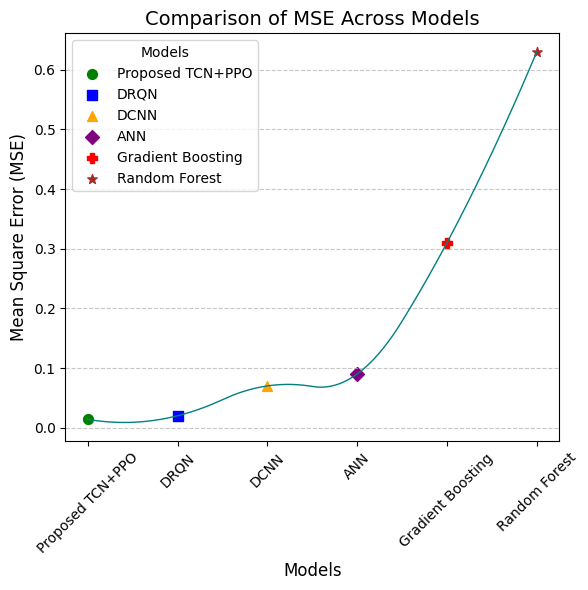

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Data for the models and their MSE values
models = [
    "Proposed TCN+PPO",
    "DRQN",
    "DCNN",
    "ANN",
    "Gradient Boosting",
    "Random Forest"
]
mse_values = [0.014, 0.020, 0.070, 0.090, 0.31, 0.63]

# Convert models to numeric indices for plotting
x_vals = np.arange(len(models))

# Create a smooth curve using interpolation
spl = make_interp_spline(x_vals, mse_values, k=2)  # k=2 for a cubic spline
x_smooth = np.linspace(x_vals.min(), x_vals.max(), 500)
y_smooth = spl(x_smooth)

# Plotting the smooth curve
plt.figure(figsize=(6, 6))

# Plot the smooth curve
plt.plot(x_smooth, y_smooth, color='teal', linewidth=1)

# Plot individual model points with different markers
markers = ['o', 's', '^', 'D', 'P', '*']
colors = ['green', 'blue', 'orange', 'purple', 'red', 'brown']
for i, (model, mse) in enumerate(zip(models, mse_values)):
    plt.scatter(i, mse, marker=markers[i], color=colors[i], s=50, label=model)

# Add labels and title
plt.xlabel("Models", fontsize=12)
plt.ylabel("Mean Square Error (MSE)", fontsize=12)
plt.title("Comparison of MSE Across Models", fontsize=14)

# Customize x-ticks for model names
plt.xticks(x_vals, models, rotation=45)

# Display grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add legend to the plot
plt.legend(title="Models", fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


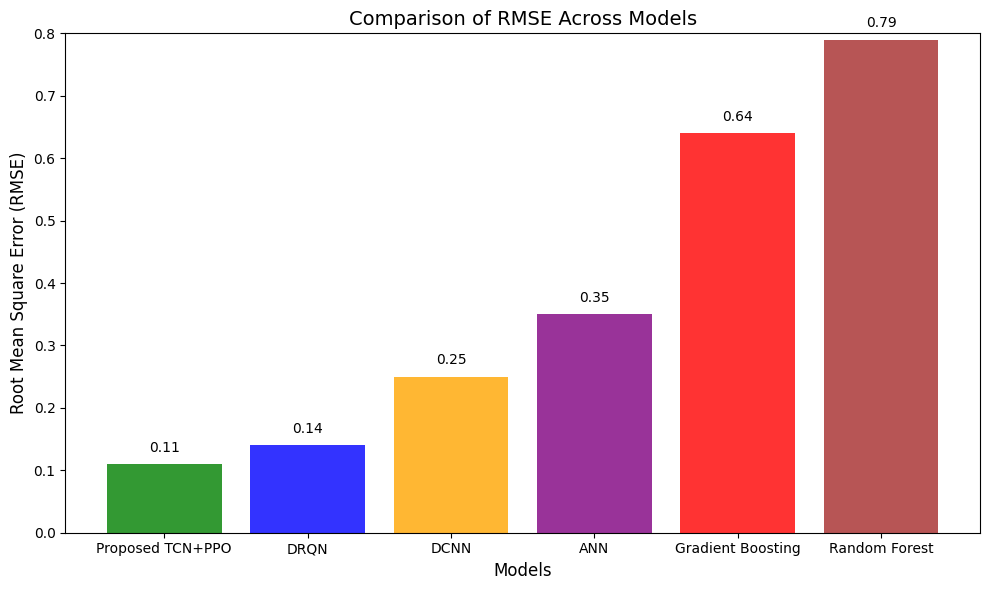

In [ ]:
import matplotlib.pyplot as plt

# Data for the models and their RMSE values
models = [
    "Proposed TCN+PPO",
    "DRQN",
    "DCNN",
    "ANN",
    "Gradient Boosting",
    "Random Forest"
]
rmse_values = [0.11, 0.14, 0.25, 0.35, 0.64, 0.79]

# Create the bar chart
plt.figure(figsize=(10, 6))
colors = ['green', 'blue', 'orange', 'purple', 'red', 'brown']
plt.bar(models, rmse_values, color=colors, alpha=0.8)

# Add labels and title
plt.xlabel("Models", fontsize=12)
plt.ylabel("Root Mean Square Error (RMSE)", fontsize=12)
plt.title("Comparison of RMSE Across Models", fontsize=14)
plt.ylim(0, 0.8)  # Set y-axis range for better clarity

# Add value annotations on top of bars
for i, value in enumerate(rmse_values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

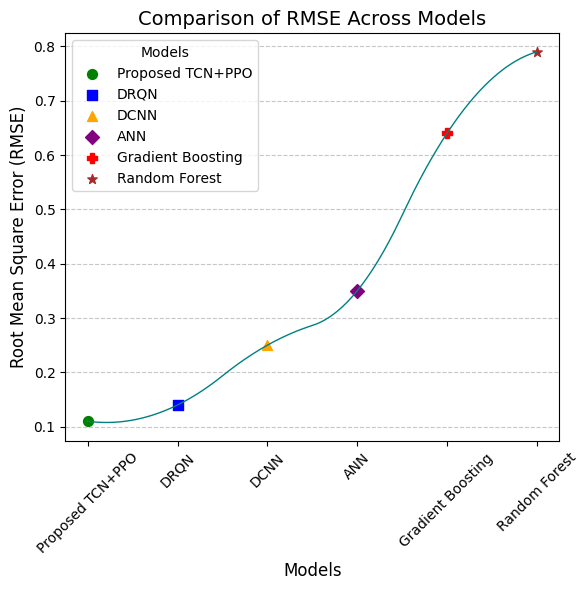

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Data for the models and their RMSE values
models = [
    "Proposed TCN+PPO",
    "DRQN",
    "DCNN",
    "ANN",
    "Gradient Boosting",
    "Random Forest"
]
rmse_values = [0.11, 0.14, 0.25, 0.35, 0.64, 0.79]

# Convert models to numeric indices for plotting
x_vals = np.arange(len(models))

# Create a smooth curve using interpolation
spl = make_interp_spline(x_vals, rmse_values, k=2)  # k=2 for a cubic spline
x_smooth = np.linspace(x_vals.min(), x_vals.max(), 500)
y_smooth = spl(x_smooth)

# Plotting the smooth curve
plt.figure(figsize=(6, 6))

# Plot the smooth curve
plt.plot(x_smooth, y_smooth, color='teal', linewidth=1)

# Plot individual model points with different markers
markers = ['o', 's', '^', 'D', 'P', '*']
colors = ['green', 'blue', 'orange', 'purple', 'red', 'brown']
for i, (model, rmse) in enumerate(zip(models, rmse_values)):
    plt.scatter(i, rmse, marker=markers[i], color=colors[i], s=50, label=model)

# Add labels and title
plt.xlabel("Models", fontsize=12)
plt.ylabel("Root Mean Square Error (RMSE)", fontsize=12)
plt.title("Comparison of RMSE Across Models", fontsize=14)

# Customize x-ticks for model names
plt.xticks(x_vals, models, rotation=45)

# Display grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add legend to the plot
plt.legend(title="Models", fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


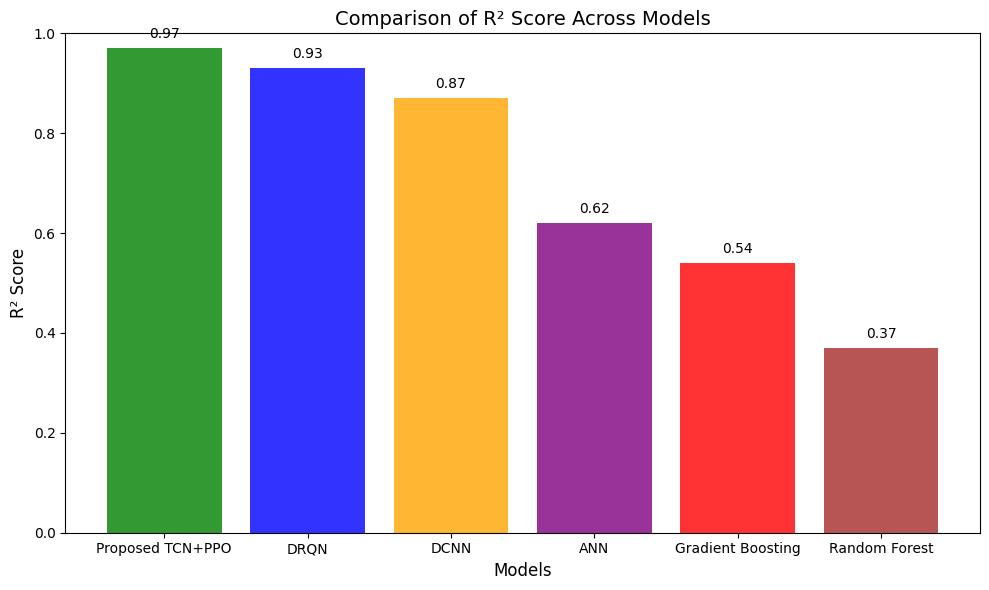

In [ ]:
import matplotlib.pyplot as plt

# Data for the models and their R² Score
models = [
    "Proposed TCN+PPO",
    "DRQN",
    "DCNN",
    "ANN",
    "Gradient Boosting",
    "Random Forest"
]
R_Square_score = [0.97, 0.93, 0.87, 0.62, 0.54, 0.37]

# Create the bar chart
plt.figure(figsize=(10, 6))
colors = ['green', 'blue', 'orange', 'purple', 'red', 'brown']
plt.bar(models, R_Square_score, color=colors, alpha=0.8)

# Add labels and title
plt.xlabel("Models", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.title("Comparison of R² Score Across Models", fontsize=14)
plt.ylim(0, 1)  # Set y-axis range for better clarity

# Add value annotations on top of bars
for i, value in enumerate(R_Square_score):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

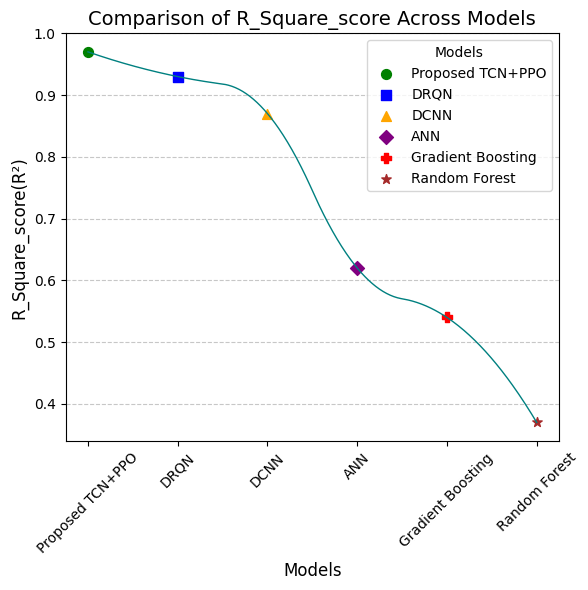

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Data for the models and their R² Score
models = [
    "Proposed TCN+PPO",
    "DRQN",
    "DCNN",
    "ANN",
    "Gradient Boosting",
    "Random Forest"
]
R_Square_score = [0.97, 0.93, 0.87, 0.62, 0.54, 0.37]

# Convert models to numeric indices for plotting
x_vals = np.arange(len(models))

# Create a smooth curve using interpolation
spl = make_interp_spline(x_vals, R_Square_score, k=2)  # k=2 for a cubic spline
x_smooth = np.linspace(x_vals.min(), x_vals.max(), 500)
y_smooth = spl(x_smooth)

# Plotting the smooth curve
plt.figure(figsize=(6, 6))

# Plot the smooth curve
plt.plot(x_smooth, y_smooth, color='teal', linewidth=1)

# Plot individual model points with different markers
markers = ['o', 's', '^', 'D', 'P', '*']
colors = ['green', 'blue', 'orange', 'purple', 'red', 'brown']
for i, (model, rmse) in enumerate(zip(models, R_Square_score)):
    plt.scatter(i, rmse, marker=markers[i], color=colors[i], s=50, label=model)

# Add labels and title
plt.xlabel("Models", fontsize=12)
plt.ylabel("R_Square_score(R²)", fontsize=12)
plt.title("Comparison of R_Square_score Across Models", fontsize=14)

# Customize x-ticks for model names
plt.xticks(x_vals, models, rotation=45)

# Display grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add legend to the plot
plt.legend(title="Models", fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.optimizers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
#import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from sklearn.svm import SVR
from tensorflow.keras.layers import SimpleRNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge

In [ ]:

svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svm_model.fit(X_scaled, y_scaled)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
y_pred_svr = svm_model.predict(X_val_reshaped)
r2_svr = r2_score(y_val, y_pred_svr)
print("r2:", r2_svr)

r2: 0.1561133357557012


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:

lr_model = LinearRegression()
lr_model.fit(X_scaled, y_scaled)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
y_pred_lr = lr_model.predict(X_val_reshaped)
r2_lr = r2_score(y_val, y_pred_lr)
print("r2:", r2_lr)

r2: 0.682950895309393


In [ ]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_scaled, y_scaled)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
y_pred_dtr = dt_model.predict(X_val_reshaped)
r2_dtr = r2_score(y_val, y_pred_dtr)
print("r2:", r2_dtr)



r2: 0.9029429655591281


In [ ]:

knn_model = KNeighborsRegressor(n_neighbors=10)
knn_model.fit(X_scaled, y_scaled)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
y_pred_knn = knn_model.predict(X_val_reshaped)
r2_knn = r2_score(y_val, y_pred_knn)
print("r2:", r2_knn)


r2: 0.821068265838786


In [ ]:
gbdt_model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=6, random_state=42)
gbdt_model.fit(X_scaled, y_scaled)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
y_pred_gbr = gbdt_model.predict(X_val_reshaped)
r2_gbr = r2_score(y_val, y_pred_gbr)
print("r2:", r2_gbr)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


r2: 0.8955383792445301


In [ ]:
import statsmodels.api as sm
X_scaled = sm.add_constant(X_scaled)
logit_model = sm.OLS(y_scaled, X_scaled)
logit_result = logit_model.fit()
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_val_reshaped = sm.add_constant(X_val_reshaped)
y_pred_log = logit_result.predict(X_val_reshaped)
r2_log = r2_score(y_val, y_pred_log)
print("R-squared:", r2_log)



R-squared: 0.682950895309397


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

alpha = 0.2  # regularization parameter
l1_ratio = 0.5  # mixing parameter, where 0 <= l1_ratio <= 1
enet_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
enet_model.fit(X_scaled, y_scaled)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
y_pred_en = enet_model.predict(X_val_reshaped)
r2_en = r2_score(y_val, y_pred_en)
print("R-squared:", r2_en)



R-squared: -0.0019982511247331747


In [ ]:

huber_model = HuberRegressor()
huber_model.fit(X_scaled, y_scaled)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
y_pred_hr = huber_model.predict(X_val_reshaped)
r2_hr = r2_score(y_val, y_pred_hr)
print("R-squared:", r2_hr)


R-squared: 0.7694099290659937


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
ridge_model = Ridge(alpha=4.0)
ridge_model.fit(X_scaled, y_scaled)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
y_pred_ridge = ridge_model.predict(X_val_reshaped)
r2_ridge = r2_score(y_val, y_pred_ridge)
print("R-squared:", r2_ridge)


R-squared: 0.6970855344199196


In [ ]:

lasso_model = Lasso(alpha=5.0)
lasso_model.fit(X_scaled, y_scaled)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
y_pred_lasso = lasso_model.predict(X_val_reshaped)
r2_lasso = r2_score(y_val, y_pred_lasso)
print("R-squared:", r2_lasso)



R-squared: -0.0019982511247331747


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_scaled, y_scaled)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
y_pred_brr = bayesian_ridge_model.predict(X_val_reshaped)
r2_brr = r2_score(y_val, y_pred_brr)
print("R-squared:", r2_brr)


R-squared: 0.6839772226940469


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:

lgbm = lgb.LGBMRegressor(num_leaves=2,max_depth=1, learning_rate=0.1)
lgbm.fit(X_scaled, y_scaled)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
y_pred_lgbm = lgbm.predict(X_val_reshaped)
r2_lgbm = r2_score(y_val, y_pred_lgbm)
print("R-squared:", r2_lgbm)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 11
[LightGBM] [Info] Start training from score 0.226252
R-squared: 0.6828054205848141


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


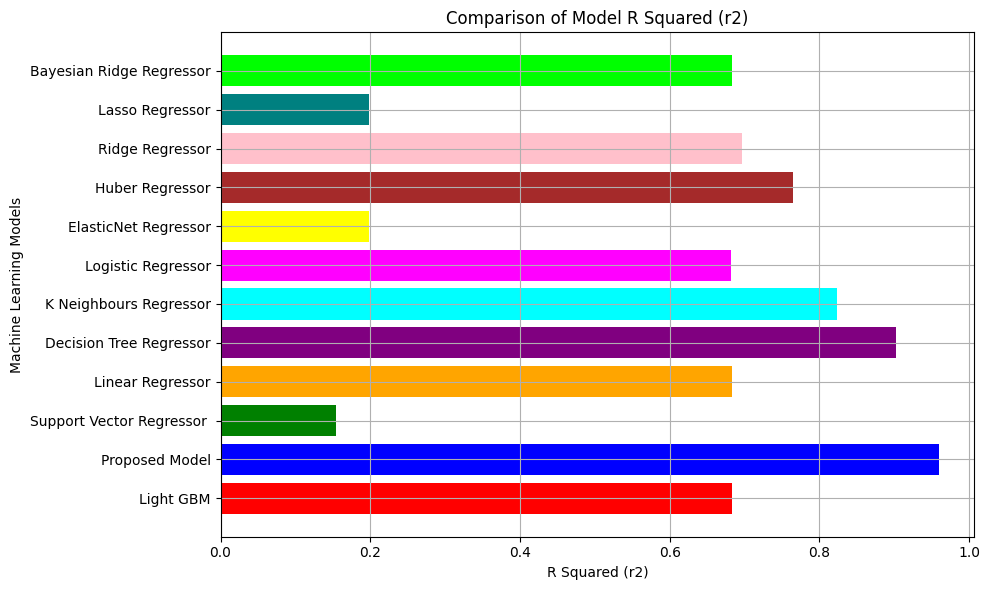

In [ ]:
results = {
    'Light GBM': 0.6828,
    'Proposed Model': 0.9591,
    'Support Vector Regressor '  :  0.1545,
    'Linear Regressor'  :  0.6829,
    'Decision Tree Regressor'  :  0.9029,
    'Linear Regressor'  :  0.6829,
    'K Neighbours Regressor'  :  0.8236,
    'Logistic Regressor'  :   0.6821,
    'ElasticNet Regressor'  :  0.1988,
    'Huber Regressor'  :  0.7653,
    'Ridge Regressor'  :  0.6970,
    'Lasso Regressor'  :  0.1983,
    'Bayesian Ridge Regressor'  :   0.6829,

}
models = list(results.keys())
accuracies = list(results.values())
num_models = len(models)

# Define a set of distinct colors
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink',
          'teal', 'lime', 'lavender', 'violet', 'salmon', 'olive']

plt.figure(figsize=(10, 6))
bars = plt.barh(models, accuracies, color=colors)
plt.title('Comparison of Model R Squared (r2)')
plt.xlabel('R Squared (r2)')
plt.ylabel('Machine Learning Models')
plt.grid(True)
plt.tight_layout()
plt.show()